# Proyecto 1

Temas Selectos de Tecnologías del lenguaje

Semestre 2018-1

Olivares Castillo José Luis


# Descripción
Este trabajo es una tarea de aprendizaje supervisado que consiste en la clasificación de tweets en:
* Positivos
* Negativos


# Método de aprendizaje
El método de aprendizaje utilizado es el algoritmo de [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) que está incluido en la biblioteca de Machine Learning [Scikit-learn](http://scikit-learn.org/stable/), en específico una variación de este algoritmo que se llama [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) que se utiliza generalmente para clasificación de texto.

Se elige este método ya que es escalable y computacionalmente no es muy complejo durante la etapa de entrenamiento.



# Dependecias
* [Scikit-learn](http://scikit-learn.org/stable/)
* [Numpy](http://www.numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [NLTK](http://www.nltk.org/)
* [stop_words](https://pypi.python.org/pypi/stop-words)
* [snowballstemmer](https://pypi.python.org/pypi/snowballstemmer)
* [matplotlib](https://matplotlib.org/)


In [1]:
# -*- coding: utf-8 -*-
"""
    @author: jose 
    FI UNAM
    Created on Thu Oct  26 21:22:06 2017
"""

from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import TweetTokenizer
import os
import numpy as np
import pandas as pd
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import snowballstemmer
import matplotlib.pyplot as plt
%matplotlib inline

# Datasets
Los datasets usados son tweets etiquetados de la siguiente manera:
* 1 para tweets positivos.
* 2 para tweets negativos.



In [2]:
home = os.getcwd()
os.chdir(home + '/data')
os.getcwd()
pos_tweets = pd.read_csv('true_posi.txt', sep="\t", names=["Etiqueta","Tweet"])
neg_tweets = pd.read_csv('true_negs.txt', sep="\t", names=["Etiqueta","Tweet"])
os.chdir(home)

In [3]:
pos_tweets.head(10)

,Etiqueta,Tweet
0,1,@_FerTf grosera jaja muy amable usted igual de...
1,1,@KarenkaaPanqee wooow!!! ^^!! No me muero sin ...
2,1,@akhs190lo hago para gustarte mas mi amor! :) ...
3,1,"@miriworld Si, por favor (:"
4,1,Hay porfin en mi casita (:
5,1,YA SERA N A V I D A D :)
6,1,@tanhdez Ni muy my ni tan tan... Felicidades T...
7,1,@agusveal @jk_blacksmith @abpise @omarfierrot ...
8,1,@cessleon #YoQuieroParaNavidad salir aunquesea...
9,1,fiesta de pizzas (:


In [4]:
neg_tweets.head(10)

,Etiqueta,Tweet
0,2,Prohibido subir un gramo de aquí a diciembre :(
1,2,BUENO SIGO DEPRIMIDA SIN MI CELULAR Y MI NEXTE...
2,2,@miguelgali11 mikeeeee!! como q estas enfermoo...
3,2,RT @mariowanna83: Esos Reyes no me trajeron mi...
4,2,Perdon es lo unico que puedo pedirte :( Patric...
5,2,Te baje las estrellas de un solo golpe ):
6,2,Pfff... pues ya esta :(
7,2,@Armando_Steeler &gt; hey no soy americanista :(
8,2,soy un diestro con alma de zurdo... dios me ca...
9,2,No quiero sentir hambre :(


# Tamaño de datasets

In [5]:
print("# de tweets con etiqueta positiva:",pos_tweets.__len__())

# de tweets con etiqueta positiva: 5496


In [6]:
print("# de tweets con etiqueta negativa:",neg_tweets.__len__())

# de tweets con etiqueta negativa: 6670


# Tamaño total de tweets

In [7]:
tweets = pd.concat([pos_tweets,neg_tweets])
print("# total de tweets:",tweets.__len__())

# total de tweets: 12166


# Descripción del dataset
La biblioteca [Pandas](https://pandas.pydata.org/) permite hacer un análisis del dataset, en este caso se agrupan todos los tweets por sus etiquetas y se obtiene lo siguiente:

In [8]:
tweets.groupby('Etiqueta').describe()

Tweet                              
         count unique               top freq
Etiqueta                                    
1         5496   5481       Buen día :)    3
2         6670   6642  Me siento mal :(    5

De la tabla anterior podemos observar el total de tweets tanto positivos como negativos, así como los que están repetidos que están en el renglón `top` y la frecuencia con la que se repitieron

# Preprocesamiento del dataset

Para preprocesar los tweets antes de iniciar la etapa de entrenamiento, se realiza lo siguiente:

* Tokenización: La biblioteca de [NLTK](http://www.nltk.org/) tiene una clase dedicada para tokenizar tweets, donde se puede convertir cada token a minúsculas, se eliminan caracteres repetidos i.e. (hooooooola -> hola) y se pueden eliminar los usuarios que estén mencionados dentro del tweet. También permite reconocer emoticonos como :) :( :D :S :* etc.

* Stemming: El stemming se aplica a los tokens para reducir las palabras a su raíz y así evitar tener variaciones de una misma palabra que pudieran afectar el desempeño del algoritmo.

* Listas de paro: Se utilizan listas de paro para eliminar de los tweets signos de puntuación y palabras funcionales que no aportan información relevante al contenido de los tweets.

In [9]:
tknzr = TweetTokenizer(preserve_case=False,       # Convertir a minúsculas
                       reduce_len=True,           # Reducir caracteres repetidos
                       strip_handles=True)        # Mostrar @usuarios

stemmer = snowballstemmer.stemmer('Spanish')

lista_de_paro = ['"',"“","/","(",")","[","]","?","¿","!","¡",
                 "rt",":","…",",","\n","#","@","\t","",".","$",
                 "...","-","🤢","newLineCharacter","|","%","<","=",
                 ">","+"]

es_stop = get_stop_words('es')

# `Limpiar` tweets 

In [10]:
def clean_tweet(tweet):
    """
    Eliminar tokens que:
    - Estén dentro de lista_de_paro.
    - Sean ligas.
    - Si es una mención i.e @potus, se cambia por token genérico @usuario.
    """
    return [stemmer.stemWord(_) for _ in tweet 
            if _ not in lista_de_paro
            and not _.startswith(('http', 'htt'))
            and _ not in es_stop]           

In [11]:
clean_tuit = []
for tuit in tweets["Tweet"]:
    clean_tokens = clean_tweet(tknzr.tokenize(tuit))
    clean_tuit.append(' '.join(clean_tokens))

### Se actualizan el dataframe con los tweets preprocesados

In [12]:
tweets["Tweet"] = clean_tuit

# Tweet preprocesados

In [13]:
tweets.groupby('Etiqueta').describe()

Tweet                    
         count unique     top freq
Etiqueta                          
1         5496   5354  hol :)   21
2         6670   6482      :(   30

De la tabla anterior se observa que una vez preprocesados los tweets, los que tienen etiqueta 1 (positiva) se caracterizan por tener "hol :)" y los tweets negativos se caracterizan por tener un emoticon 'triste' :(

# Longitud de tweets

Se añade una columna donde se almacena la longitud de los tweets, esto con el fin de averiguar si la longitud del tweet tiene alguna relación con la clase a la que pertenece.

In [14]:
tweets['length'] = tweets['Tweet'].apply(len)

In [15]:
tweets.head(10)

,Etiqueta,Tweet,length
0,1,groser jaj amabl usted igual descans mañan mue...,63
1,1,wooow ^ ^ muer ir contig :),27
2,1,hag gustart mas amor :) jiji,28
3,1,si favor (:,11
4,1,porfin casit (:,15
5,1,ser n v i d d :),16
6,1,my tan tan felic tanii mand bes fuert abraz :),46
7,1,igual hac fri si mand abraz molest :),37
8,1,#yoquieroparanav sal aunquese camin the walkin...,55
9,1,fiest pizz (:,13


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27adcda908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f27add3be48>], dtype=object)

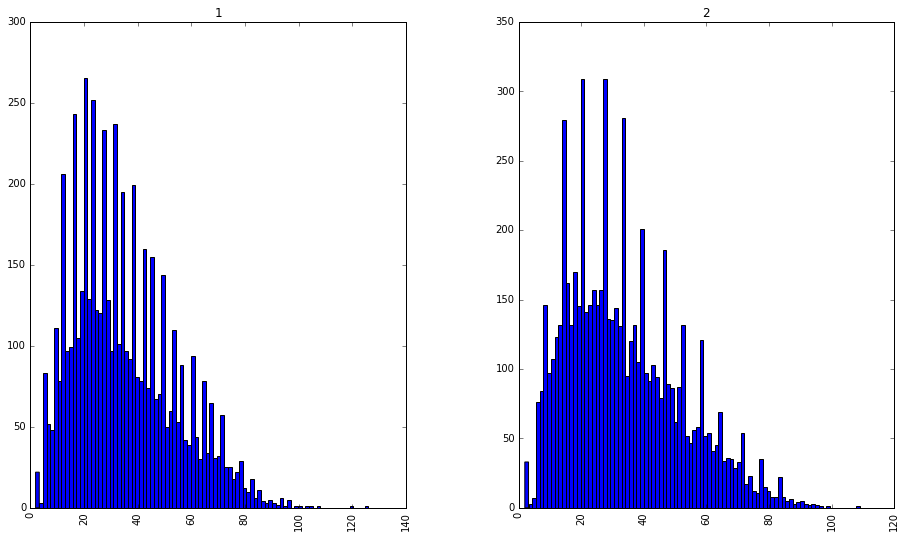

In [16]:
tweets.hist(column='length',by ='Etiqueta',bins=90,figsize = (15,9))

De estas gráficas se observa que los tweets positivos y positivos tienen una distribución similar, sin embargo, la longitud de los tweets negativos supera los 120 caracteres y los tweets positivos se quedan en una longitud de 100 en promedio.

# Representación vectorial
Para la representación vectorial de los tweets se utiliza la clase `TfidfVectorizer` que está incluida en la biblioteca de [Scikit-learn](http://scikit-learn.org/stable/). Esta clase crea una matriz TF-IDF para los tweets. 

In [17]:
vectorizer = TfidfVectorizer(use_idf=True,               # Usa medida IDF
                             lowercase=True,             # Convierte tokens a minúsculas.
                             strip_accents='ascii',      # Elimina acentos y caracteres especiales
                             smooth_idf=True             # Aplica alisado para prevenir divisiones entre cero.
                             #stop_words=stopset
                            )

In [18]:
X = vectorizer.fit_transform(tweets["Tweet"])
y = tweets["Etiqueta"]

La representación vectorial de los tweets es una matriz dispersa de dimensión:

In [19]:
print(X.shape)

(12166, 10682)


### Matriz dispersa

In [20]:
print(X)

  (0, 4535)	0.378494145746
  (0, 5279)	0.212427252826
  (0, 632)	0.397188425839
  (0, 10077)	0.286631623376
  (0, 4979)	0.25755608953
  (0, 2969)	0.278342123988
  (0, 6060)	0.216210920489
  (0, 6607)	0.415882705932
  (0, 4208)	0.278342123988
  (0, 7557)	0.361539912449
  (1, 10511)	0.648417630031
  (1, 6600)	0.455357638544
  (1, 5204)	0.372666696331
  (1, 2504)	0.483035745604
  (2, 4642)	0.383755932838
  (2, 4603)	0.634597252799
  (2, 6150)	0.290266329294
  (2, 708)	0.342081293486
  (2, 5403)	0.49874197485
  (3, 8995)	0.439888309413
  (3, 4031)	0.898052490248
  (4, 7838)	0.736637807743
  (4, 1894)	0.676287468613
  (5, 8928)	1.0
  (6, 6666)	0.375907293831
  :	:
  (12160, 3710)	0.455055240286
  (12160, 6789)	0.396193856035
  (12161, 1884)	0.618397532516
  (12161, 5822)	0.619856205755
  (12161, 8235)	0.483076366597
  (12162, 8113)	0.308110710131
  (12162, 10239)	0.36803566992
  (12162, 6269)	0.580410221427
  (12162, 7644)	0.406290855763
  (12162, 3412)	0.517367617227
  (12163, 8719)	0.2654

# Evaluación 
Se separa el dataset en subconjuntos de entretamiento y prueba, para esto se utiliza la clase [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). los datos se dividen en 75% para el conjunto de entrenamiento y 25% para el conjunto de pruebas

### Segmentación del dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42,
                                                    shuffle = True)

# Clasificador Naive Bayes
Se instancia el clasificador [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) en su versión de [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) con lo siguientes parámetros:

* `alpha = 0.42`: Constante para aplicar alisado.
* `fit_prior = True`: Para considerar las probabilidades prior de las clases


In [22]:
clf = MultinomialNB(alpha=0.42,fit_prior=True)

# Entrenamiento

In [23]:
clf.fit(X_train,y_train)

MultinomialNB(alpha=0.42, class_prior=None, fit_prior=True)

# Performance

In [24]:
print(clf.score(X_test,y_test),"%")

0.77744904668 %


# Predicción de una nueva instancia

Para predecir una nueva instancia, el tweet debe ser:
* Un arreglo de tipo `np.array`.
* Obtener su representación vectorial.
* Evaluar el tweet con el clasificador.

In [25]:
def predict(z):
    new_tweet = np.array([z])
    new_tweet_vector = vectorizer.transform(new_tweet)
    print("Representación vectorial de: ", z)
    print("------" * 10)
    print(new_tweet_vector)
    print("------" * 10)
    print("Evualuación:")
    if clf.predict(new_tweet_vector)[0] == 1:
        print(z," es: positivo")
    else:
        print(z, " es: negativo")

In [26]:
z1 = "Ojalá mañana sea un buen día"
predict(z1)

Representación vectorial de:  Ojalá mañana sea un buen día
------------------------------------------------------------
  (0, 10007)	0.546318232435
  (0, 7036)	0.546318232435
  (0, 6061)	0.546318232435
  (0, 3089)	0.240335983063
  (0, 1566)	0.216443484476
------------------------------------------------------------
Evualuación:
Ojalá mañana sea un buen día  es: positivo


In [27]:
z2 = "Ya es lunes :("
predict(z2)

Representación vectorial de:  Ya es lunes :(
------------------------------------------------------------
  (0, 10574)	1.0
------------------------------------------------------------
Evualuación:
Ya es lunes :(  es: negativo


# Análisis de resultados

In [28]:
from sklearn.metrics import classification_report,confusion_matrix

In [29]:
all_predictions = clf.predict(vectorizer.transform(tweets["Tweet"]))

In [30]:
print (all_predictions)

[1 1 1 ..., 2 2 2]


In [31]:
target_names = ['clase positiva','clase negativa']
print (classification_report(tweets['Etiqueta'], all_predictions,target_names=target_names))

                precision    recall  f1-score   support

clase positiva       0.90      0.82      0.86      5496
clase negativa       0.86      0.93      0.89      6670

   avg / total       0.88      0.88      0.88     12166



In [32]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(tweets['Etiqueta'],all_predictions).ravel()

In [34]:
true_neg, false_pos, false_neg, true_pos

(4490, 1006, 479, 6191)

# Matriz de confusión

<table>
  <tr>
    <th colspan="2"></th>
    <th colspan="2">Clase predicha<br></th>
  </tr>
  <tr>
    <th rowspan="3">Clase verdadera<br></th>
    <td></td>
    <td>P</td>
    <td>N</td>
  </tr>
  <tr>
    <td>P</td>
    <td>6191</td>
    <td>1006</td>

  </tr>
  <tr>
    <td>N</td>
    <td>479</td>
    <td>4490</td>
  </tr>
</table>

# Referencias
* https://medium.com/towards-data-science/twitter-sentiment-analysis-on-car-brands-c13d449eb9fc
* https://www.ravikiranj.net/posts/2012/code/how-build-twitter-sentiment-analyzer/
* http://textblob.readthedocs.io/en/latest/advanced_usage.html#sentiment-analyzers
* https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/
* http://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
* https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
* http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html